<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/BTC_1min_LSTM_CNC_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=9bc1f0f3c6d21e4ee93888cd8d1988a41c4702013bfe2dd7b75bc5f63c4a9f13
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [13]:
import yfinance as yf
h_data = yf.download(tickers='BTC-USD', period = '7d', interval = '1m')
h_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-10-18 00:00:00+01:00,61308.359375,61308.359375,61308.359375,61308.359375,61308.359375,0
2021-10-18 00:01:00+01:00,61369.335938,61369.335938,61369.335938,61369.335938,61369.335938,32497664
2021-10-18 00:02:00+01:00,61242.125000,61242.125000,61242.125000,61242.125000,61242.125000,7143424
2021-10-18 00:03:00+01:00,61224.656250,61224.656250,61224.656250,61224.656250,61224.656250,0
2021-10-18 00:04:00+01:00,61217.828125,61217.828125,61217.828125,61217.828125,61217.828125,0
...,...,...,...,...,...,...
2021-10-24 20:05:00+01:00,60265.074219,60265.074219,60265.074219,60265.074219,60265.074219,0
2021-10-24 20:06:00+01:00,60250.324219,60250.324219,60250.324219,60250.324219,60250.324219,37621760
2021-10-24 20:07:00+01:00,60249.613281,60249.613281,60249.613281,60249.613281,60249.613281,0


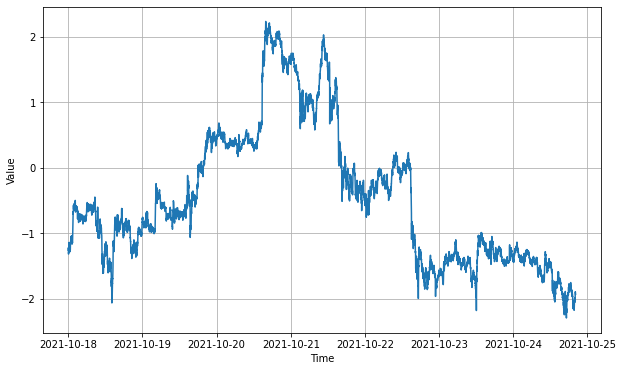

In [14]:
from sklearn.preprocessing import StandardScaler

series = h_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(h_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [15]:
split_time = 8500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(8500,)
Epoch 1/100
33/33 [==============================] - 6s 60ms/step - loss: 3.3242 - mae: 3.7886
Epoch 2/100
33/33 [==============================] - 2s 59ms/step - loss: 2.7851 - mae: 3.2505
Epoch 3/100
33/33 [==============================] - 2s 60ms/step - loss: 2.2401 - mae: 2.7098
Epoch 4/100
33/33 [==============================] - 2s 64ms/step - loss: 1.7512 - mae: 2.2174
Epoch 5/100
33/33 [==============================] - 2s 62ms/step - loss: 1.3025 - mae: 1.7634
Epoch 6/100
33/33 [==============================] - 2s 61ms/step - loss: 0.9293 - mae: 1.3679
Epoch 7/100
33/33 [==============================] - 2s 62ms/step - loss: 0.7408 - mae: 1.1274
Epoch 8/100
33/33 [==============================] - 2s 64ms/step - loss: 0.6697 - mae: 1.0347
Epoch 9/100
33/33 [==============================] - 2s 62ms/step - loss: 0.6383 - mae: 0.9990
Epoch 10/100
33/33 [=======================

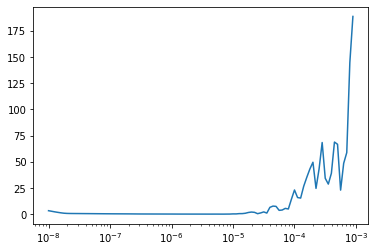

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
85/85 [==============================] - 7s 35ms/step - loss: 0.6309 - mae: 0.9985
Epoch 2/150
85/85 [==============================] - 3s 35ms/step - loss: 0.0850 - mae: 0.3141
Epoch 3/150
85/85 [==============================] - 3s 36ms/step - loss: 0.0929 - mae: 0.3405
Epoch 4/150
85/85 [==============================] - 3s 36ms/step - loss: 0.0486 - mae: 0.2310
Epoch 5/150
85/85 [==============================] - 3s 36ms/step - loss: 0.0400 - mae: 0.2020
Epoch 6/150
85/85 [==============================] - 3s 36ms/step - loss: 0.0374 - mae: 0.1908
Epoch 7/150
85/85 [==============================] - 3s 35ms/step - loss: 0.0364 - mae: 0.1891
Epoch 8/150
85/85 [==============================] - 3s 36ms/step - loss: 0.0287 - mae: 0.1606
Epoch 9/150
85/85 [==============================] - 3s 36ms/step - loss: 0.0297 - mae: 0.1697
Epoch 10/150
85/85 [==============================] - 3s 35ms/step - loss: 0.0253 - mae: 0.1513
Epoch 11/150
85/85 [=============================

In [21]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

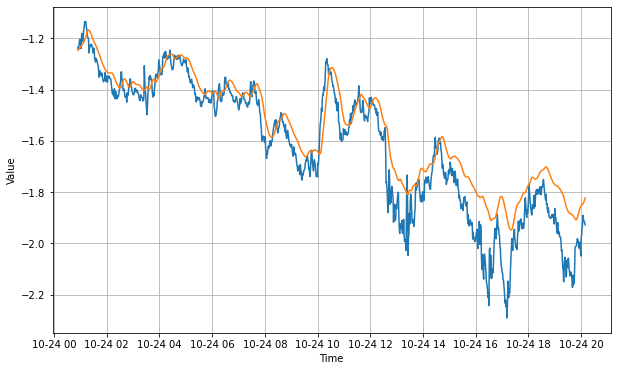

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS